a = 0.8833688681038853 +/- 0.2303230276277179
b = -12.745903411241166 +/- 1.186676943270716
a1 = 0.6402206054612433 +/- 0.2758017232240727
b1 = -14.237768027059278 +/- 1.3841662347085597


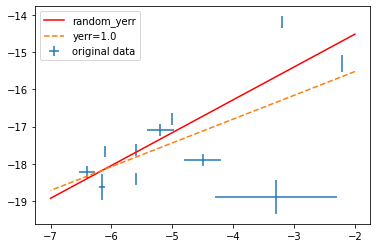

In [2]:
import sys
import os
import numpy
import matplotlib.pyplot as plt
from pylab import *
import scipy.optimize as optimization
from scipy.optimize import curve_fit


xdata = numpy.array([-5.6, -5.6, -6.1, -5.0, -3.2, -6.4, -5.2, -4.5, -2.22, -3.30, -6.15])
ydata = numpy.array([-18.40, -17.63, -17.67, -16.80, -14.19, -18.21, -17.10, -17.90, -15.30, -18.90, -18.62])


# Initial guess.
x0     = numpy.array([1.0, 1.0])
#data error
Xerr = numpy.array([0.000001, 0.000001, 0.000001, 0.0000001, 0.0000001, 0.13, 0.22, 0.30, 0.00000001, 1.0, 0.05])
Yerr_1 = numpy.array([0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.22, 0.45, 0.35])
Yerr_2 = numpy.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])          #make change

#def func(x, a, b, c):
#    return a + b*x + c*x*x


def line(x, a, b):
    return a * x + b


popt, pcov = curve_fit(line, xdata, ydata, sigma =Yerr_1)

print("a =", popt[0], "+/-", pcov[0,0]**0.5)
print("b =", popt[1], "+/-", pcov[1,1]**0.5)

#1 sigma error ######################################################################################
popt1, pcov1 = curve_fit(line, xdata, ydata, sigma = Yerr_2)                           #make change

print("a1 =", popt1[0], "+/-", pcov1[0,0]**0.5)
print("b1 =", popt1[1], "+/-", pcov1[1,1]**0.5)
#####################################################################################################

plt.errorbar(xdata, ydata, xerr= Xerr,yerr=Yerr_1, fmt="none",label='original data')
xfine = np.linspace(-2.0, -7.0, 100)  # define values to plot the function for
plt.plot(xfine, line(xfine, popt[0], popt[1]), 'r-',label='random_yerr')
plt.plot(xfine, line(xfine, popt1[0], popt1[1]), '--',label='yerr=1.0')    
plt.legend()
#plt.ylim(-11.5, -19.5)
#plt.xlim(-2, -7)

plt.show()

# curve_fit

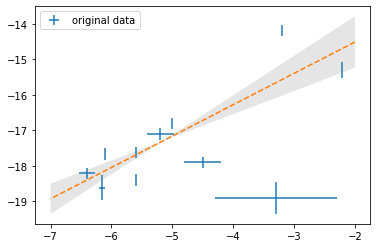

In [3]:
y  = line(xfine, popt[0], popt[1])
y1 = line(xfine, popt[0] + pcov[0,0]**0.5, popt[1] - pcov[1,1]**0.5)
y2 = line(xfine, popt[0] - pcov[0,0]**0.5, popt[1] + pcov[1,1]**0.5)


y3 = line(xfine, popt[0] + pcov[0,0]**0.5, popt[1] + pcov[1,1]**0.5)
y4 = line(xfine, popt[0] - pcov[0,0]**0.5, popt[1] - pcov[1,1]**0.5)

plt.errorbar(xdata, ydata, xerr= Xerr,yerr=Yerr_1, fmt="none",label='original data')
plt.plot(xfine, y, '--')
#plt.plot(xfine, y1, '-',color='gray')
#plt.plot(xfine, y2, '-',color='gray')
#plt.fill_between(xfine, y1, y2, facecolor="gray", alpha=0.2)
plt.fill_between(xfine, y3, y4, facecolor="gray", alpha=0.2)
plt.legend(loc='upper left')
plt.show()

# pymc

https://github.com/pymc-devs/pymc/wiki/StraightLineFit

In [4]:
"""
Straight line fit -- linear regression
======================================

This is probably the most widespread problems in statistics: estimating the
slope and ordinate of a linear relationship y = ax+b given some data (x,y).

The standard least-square (SLS) solution to this problem assumes that the input
data x is exact, and that errors only affect output measurements y. In many
instances, this assumption does not hold and using the same SLS method yields
biased parameters: the slope is underestimated and the ordinate overestimated.

Here, both input and output data are assumed to be corrupted by errors of zero
mean and variances of sigma_x and sigma_y respectively. Under these assumptions,
the most general statistical distribution (maximum entropy) is the normal
distribution. In the following, the parameter distribution is sampled by
marginalizing x from

.. math::
    p(a,b,x \mid \tilde{x}, \tilde{y}) = p(\tilde{y} \mid a, b, x) p(\tilde{x} \mid x) p(x) p(a,b),

where p(x) stands for the prior for the true input and p(a,b) the prior for the
regression parameters.
"""


from pymc import stochastic, observed, deterministic, uniform_like, runiform, rnormal, Sampler, Normal, Uniform
from numpy import inf, log, cos,array
import pylab

# ------------------------------------------------------------------------------
# Synthetic values
# Replace by real data
# ------------------------------------------------------------------------------
slope = 1.5
intercept = 4
N = 30
true_x = runiform(0,50, N)
true_y = slope*true_x + intercept
data_y = rnormal(true_y, 2)
data_x = rnormal(true_x, 2)



# ------------------------------------------------------------------------------
# Calibration of straight line parameters from data
# ------------------------------------------------------------------------------


@stochastic
def theta(value=array([2.,5.])):
    """Slope and intercept parameters for a straight line.
    The likelihood corresponds to the prior probability of the parameters."""
    slope, intercept = value
    prob_intercept = uniform_like(intercept, -10, 10)
    prob_slope = log(1./cos(slope)**2)
    return prob_intercept+prob_slope

init_x = data_x.clip(min=0, max=50)

# Inferred true inputs.
x = Uniform('x', lower=0, upper=50, value=init_x)

@deterministic(plot=False)
def modelled_y(x=x, theta=theta):
    """Return y computed from the straight line model, given the
    inferred true inputs and the model paramters."""
    slope, intercept = theta
    return slope*x + intercept


"""
Input error model.

    Define the probability of measuring x knowing the true value.
"""
measured_input = Normal('measured_input', mu=x, tau=2, value=data_x, observed=True)

"""
Output error model.
    Define the probability of measuring x knowing the true value.
    In this case, the true value is assumed to be given by the model, but
    structural errors could be integrated to the analysis as well.
"""
y = Normal('y', mu=modelled_y, tau=2, value=data_y, observed=True)

In [5]:
x

<pymc.distributions.new_dist_class.<locals>.new_class 'x' at 0x1129ab358>

In [12]:
y

<pymc.distributions.new_dist_class.<locals>.new_class 'y' at 0x121cd49b0>

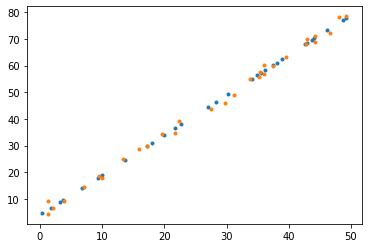

In [7]:
plt.errorbar(true_x,true_y,fmt='.')
plt.errorbar(data_x,data_y,fmt='.')
plt.show()

# pymc3 a example

In [ ]:
http://mattpitkin.github.io/samplers-demo/pages/pymc3/

## create data

In [13]:
"""
Setup a model and data
"""

import numpy as np

# set the true values of the model parameters for creating the data
m = 3.5 # gradient of the line
c = 1.2 # y-intercept of the line

# set the "predictor variable"/abscissa
M = 100
xmin = 0.
xmax = 10.
stepsize = (xmax-xmin)/M
x = np.arange(xmin, xmax, stepsize)

# define the model function
def straight_line(x, m, c):
    """
    A straight line model: y = m*x + c
    
    Args:
        x (list): a set of abscissa points at which the model is defined
        m (float): the gradient of the line
        c (float): the y-intercept of the line
    """
    
    return m*x + c

# create the data - the model plus Gaussian noise
sigma = 0.5 # standard deviation of the noise
data = straight_line(x, m, c) + sigma*np.random.randn(M)



In [14]:
# -*- coding: utf-8 -*-

"""
Example of running PyMC3 to fit the parameters of a straight line.
"""

from __future__ import print_function, division

import os
import sys
import numpy as np

import matplotlib as mpl
mpl.use("Agg") # force Matplotlib backend to Agg

# import PyMC3
import pymc3 as pm

# import model and data
from createdata import *

# set the PyMC3 model
linear_model = pm.Model()

with linear_model:
    # set prior parameters
    cmin = -10. # lower range of uniform distribution on c
    cmax = 10.  # upper range of uniform distribution on c
    
    mmu = 0.     # mean of Gaussian distribution on m
    msigma = 10. # standard deviation of Gaussian distribution on m
    
    # set priors for unknown parameters
    cmodel = pm.Uniform('c', lower=cmin, upper=cmax) # uniform prior on y-intercept
    mmodel = pm.Normal('m', mu=mmu, sd=msigma)       # Gaussian prior on gradient
    
    sigmamodel = sigma # set a single standard deviation
    
    # Expected value of outcome, aka "the model"
    mu = mmodel*x + cmodel
    
    # Gaussian likelihood (sampling distribution) of observations, "data"
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigmamodel, observed=data)

Nsamples = 1000 # final number of samples
Ntune = 1000    # number of tuning samples

# perform sampling
with linear_model:
    trace = pm.sample(Nsamples, tune=Ntune, discard_tuned_samples=True) # perform sampling

# extract the samples
postsamples = np.vstack((trace['m'], trace['c'])).T

# plot posterior samples (if corner.py is installed)
try:
    import corner # import corner.py
except ImportError:
    sys.exit(1)

print('Number of posterior samples is {}'.format(postsamples.shape[0]))

fig = corner.corner(postsamples, labels=[r"$m$", r"$c$"], truths=[m, c])
fig.savefig('PyMC3.png')

ModuleNotFoundError: No module named 'pymc3'